# Rapid analysis of scientific papers from **bioRxiv** and **PubMed**

### In this notebook, we will parse synchronously and asynchronously papers from the **https://www.biorxiv.org/** and **https://www.ncbi.nlm.nih.gov/**, after that we will need scrap all words from all articles both sites and make a connection from the most commonly used words, and train the Word2vec, after that we convert it, we look at semantic similar words and write it all in pdf.

**bioRxiv - https://www.biorxiv.org/search/Connectome**

**4568 Results.**

**PubMed - https://www.ncbi.nlm.nih.gov/pubmed/?term=connectome**

**2,372 Results.**


For demonstration, I chose the theme - “[Connectome](https://en.wikipedia.org/wiki/Connectome)” in the end we will have connectome of connectomes :)
In total, we need to parse all words from all articles of both sites and make the connection connect from the most commonly used words.

<img style="display: block; margin-left: auto; margin-right: auto; width: 70%;" border="0" class="center" alt="Connectome" src="https://www.extremetech.com/wp-content/uploads/2016/01/connectome.jpg?style=centerme">


# PubMed - https://www.ncbi.nlm.nih.gov

## Synchronous scraping

**For comparison, compare synchronous and asynchronous web-scraping.**

**1h 4min 27s vs 3min 51s**

In [0]:
%%time

import requests
from bs4 import BeautifulSoup

GETURL = "https://www.ncbi.nlm.nih.gov/pubmed/?term=connectome"
POSTURL = "https://www.ncbi.nlm.nih.gov/pubmed/"


# Solution problem with pagination - https://stackoverflow.com/questions/51100224/cant-go-on-to-the-next-page-using-post-request
# as an alternative, we can use selenium.

s = requests.session()
s.headers["User-Agent"] = "Mozilla/5.0"

soup = BeautifulSoup(s.get(GETURL).text,"lxml")
inputs = {i['name']: i.get('value', '') for i in soup.select('form#EntrezForm input[name]')}

results = int(inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_ResultsController.ResultCount'])
items_per_page = 100
pages = results // items_per_page + int(bool(results % items_per_page))

inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_DisplayBar.PageSize'] = items_per_page
inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_DisplayBar.PrevPageSize'] = items_per_page
inputs['EntrezSystem2.PEntrez.DbConnector.Cmd'] = 'PageChanged'



def parse_text_from_paper(pmid):
    '''
    pmid: article id,
    return: body data and title.
    '''
    html = requests.get(f"{POSTURL}{pmid}")
    soup = BeautifulSoup(html.text, 'lxml')
    title = [text.find('h1').text for text in soup.find_all("div", class_="rprt_all")]
    data = [text.find('p').text for text in soup.find_all("div", class_="abstr")]
    return data, title[0]

def get_data(session, num_pages, inputs):
    
    """
    Iteration over the n̲u̲m̲_̲p̲a̲g̲e̲s̲ in a s̲e̲s̲s̲i̲o̲n̲
    return: MAP where keys - link on article, values - data.
    """
    
    MAP = {}
    for page in range(num_pages):
        print(f"Getting data from page №{page}")
        inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_Pager.CurrPage'] = page + 1
        inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_Pager.cPage'] = page
        res = session.post(POSTURL, inputs)
        soup = BeautifulSoup(res.text, "lxml")

        items = [pmid.text for pmid in soup('dd')]

        for pmid in items:
            
            try:
                MAP[POSTURL+pmid] = parse_text_from_paper(pmid)
            except:
                print("Problem with link - ", {POSTURL+pmid})
                MAP[POSTURL+pmid] = None

    print(f"Done!\nMap length: {len(MAP)}")
    return MAP

pubmed_MAP = get_data(s, pages, inputs)

Getting data from page №0
Getting data from page №1
Getting data from page №2
Getting data from page №3
Getting data from page №4
Problem with link -  {'https://www.ncbi.nlm.nih.gov/pubmed/30983094'}
Getting data from page №5
Getting data from page №6
Getting data from page №7
Getting data from page №8
Getting data from page №9
Getting data from page №10
Getting data from page №11
Getting data from page №12
Getting data from page №13
Getting data from page №14
Getting data from page №15
Getting data from page №16
Getting data from page №17
Getting data from page №18
Getting data from page №19
Getting data from page №20
Getting data from page №21
Getting data from page №22
Getting data from page №23
Getting data from page №24
Getting data from page №25
Getting data from page №26
Getting data from page №27
Getting data from page №28
Getting data from page №29
Getting data from page №30
Getting data from page №31
Getting data from page №32
Getting data from page №33
Getting data from page

# PubMed - https://www.ncbi.nlm.nih.gov

## Asynchronous scraping

In [0]:
# Solution problem with Event Loop in Jupyter kernel https://github.com/jupyter/notebook/issues/3397#issuecomment-376803076

#!pip install nest_asyncio

#import nest_asyncio
#nest_asyncio.apply()

In [0]:
!pip install aiohttp -qq

     |████████████████████████████████| 1.2MB 4.7MB/s 
     |████████████████████████████████| 256kB 28.5MB/s 
     |████████████████████████████████| 153kB 26.9MB/s 


In [0]:
%%time

import asyncio
import aiohttp
import socket

#import requests
from bs4 import BeautifulSoup


GETURL = "https://www.ncbi.nlm.nih.gov/pubmed/?term=connectome"
POSTURL = "https://www.ncbi.nlm.nih.gov/pubmed/"


PMID = []
NUM_PAGES = 46
ITEMS_PER_PAGE = 100


pubmed_MAP = {}
SEMA = asyncio.BoundedSemaphore(300)

####################### Get all PMID #########################

async def get_session_and_inputs(page, items_per_page):

    headers = {"User-Agent" : "Mozilla/5.0", "Connection": "close"}
    async with aiohttp.ClientSession(headers=headers) as session:
        async with session.get(GETURL) as response:
            data = await response.text()
            soup = BeautifulSoup(data, "lxml")

            inputs = {i['name']: i.get('value', '') for i
                      in soup.select('form#EntrezForm input[name]')}
            inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_DisplayBar.PageSize'] = ITEMS_PER_PAGE
            inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_DisplayBar.PrevPageSize'] = ITEMS_PER_PAGE
            inputs['EntrezSystem2.PEntrez.DbConnector.Cmd'] = 'PageChanged'

            inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_Pager.CurrPage'] = page
            inputs['EntrezSystem2.PEntrez.PubMed.Pubmed_ResultsPanel.Pubmed_Pager.cPage'] = page

        async with session.post(POSTURL, data=inputs) as response2:
            data = await response2.text()
            soup = BeautifulSoup(data, "lxml")
            PMID.append([pmid.text for pmid in soup('dd')])


async def get_all_pmid():
    tasks = []
    for page in range(NUM_PAGES):
        task = asyncio.ensure_future(get_session_and_inputs(page=page,
                                                            items_per_page=NUM_PAGES))
        tasks.append(task)

    await asyncio.gather(*tasks)

############# Get all data in MAP from each uniq PMID articles ###################

async def parse_text_from_paper(pmid):
    '''
    From link to science paper (pmid) - get html,
    then get document's body (data) from one page.
    '''
    
    conn = aiohttp.TCPConnector(family=socket.AF_INET)
    headers={"User-Agent" : "Mozilla/5.0",
             "Connection": "close"}
    
    async with aiohttp.ClientSession(headers=headers, connector=conn) as session:
        async with SEMA, session.get(f"https://www.ncbi.nlm.nih.gov/pubmed/{pmid}") as response:
            data = await response.text()
            soup = BeautifulSoup(data, "lxml")

            title = [text.find('h1').text for text in soup.find_all("div", class_="rprt_all")]
            data = [text.find('p').text for text in soup.find_all("div", class_="abstr")]
            pubmed_MAP[POSTURL+pmid] = data, title[0]

async def get_all_data():

    tasks = []
    pmid_items = [pmid_i for lst in PMID for pmid_i in lst]

    for pmid in pmid_items:

        task = asyncio.ensure_future(parse_text_from_paper(pmid))
        tasks.append(task)

    await asyncio.gather(*tasks)


loop = asyncio.get_event_loop()
loop.run_until_complete(get_all_pmid())
loop = asyncio.get_event_loop()
loop.run_until_complete(get_all_data())
    
print(f"Done!\nMap length: {len(pubmed_MAP)}")

Done!
Map length: 4500
CPU times: user 3min 41s, sys: 2.6 s, total: 3min 43s
Wall time: 3min 51s


Remove NoneType from data dict

In [0]:
print(len(pubmed_MAP))
filtered = {k: v for k, v in pubmed_MAP.items() if v is not None}
pubmed_MAP.clear()
pubmed_MAP.update(filtered)
print(len(pubmed_MAP))

4500
4500


# bioRxiv - https://www.biorxiv.org
## Synchronous scraping



**For comparison, compare synchronous and asynchronous web-scraping.**

**53min 16s vs 2min 28s**

In [0]:
%%time

import requests
from bs4 import BeautifulSoup
import time

MAP2 = dict()
NUM_PAGE =  32 # items per page 75
GETURL = "https://www.biorxiv.org/search/connectome%20numresults%3A75%20sort%3Arelevance-rank?page="
MAIN_URL = "https://www.biorxiv.org"

def get_data_from_page(num):

    '''
    Get data (all links) to science papers from one page, then
    from paper-links get a paper link, after which we get the document's title and body
    from html, and write it into the dictionary value with the key link to the paper.
    '''
    print(f"Getting data from page: {num}")
    main_url = "https://www.biorxiv.org"
    data = requests.get(f"{GETURL}{num}")
    soup = BeautifulSoup(data.text, 'lxml')
    paper_links = [MAIN_URL + i.get("href")for i in 
                   soup.find_all(name='a',class_='highwire-cite-linked-title')]
    #print(paper_links)

    for idx, link in enumerate(paper_links):
        try:
    
            data = requests.get(link)
            soup = BeautifulSoup(data.text, "lxml")
            title = soup.find("h1", {"id": "page-title"}).text
            MAP2[paper_links[idx]] = [p.text for p in 
                                     soup.find("div", {"id": "abstract-1"}).find_all('p')], title
        except:
            print(f"WARNING: Problem with this link - {paper_links[idx]}") 
            continue


while NUM_PAGE != 0:
    get_data_from_page(NUM_PAGE)
    NUM_PAGE -= 1

print(f"Done!\nMap length: {len(MAP2)}")

Getting data from page: 32
Getting data from page: 31
Getting data from page: 30
Getting data from page: 29
Getting data from page: 28
Getting data from page: 27
Getting data from page: 26
Getting data from page: 25
Getting data from page: 24
Getting data from page: 23
Getting data from page: 22
Getting data from page: 21
Getting data from page: 20
Getting data from page: 19
Getting data from page: 18
Getting data from page: 17
Getting data from page: 16
Getting data from page: 15
Getting data from page: 14
Getting data from page: 13
Getting data from page: 12
Getting data from page: 11
Getting data from page: 10
Getting data from page: 9
Getting data from page: 8
Getting data from page: 7
Getting data from page: 6
Getting data from page: 5
Getting data from page: 4
Getting data from page: 3
Getting data from page: 2
Getting data from page: 1
Done!
Map length: 2368
CPU times: user 2min 6s, sys: 2.25 s, total: 2min 8s
Wall time: 53min 16s


# Biorxiv - https://www.biorxiv.org
##Asynchronous scraping

In [0]:
%%time

import asyncio
import aiohttp

import requests
from bs4 import BeautifulSoup

GETURL = "https://www.biorxiv.org/search/connectome%20numresults%3A75%20sort%3Arelevance-rank?page="
MAIN_URL = "https://www.biorxiv.org"
PAPER_LINKS = []
NUM_PAGES = 32
biorxiv_MAP = {}

async def fetch_links_from_page(page, session, geturl=GETURL):
    """
    corutine parse links on paper from page
    and added there into list.
    """

    async with session.get(f"{geturl}{page}") as response:
        data = await response.text()
        soup = BeautifulSoup(data, "lxml")

        PAPER_LINKS.append([MAIN_URL + i.get("href")for i in 
                         soup.find_all(name='a',class_='highwire-cite-linked-title')])



async def get_paper_links():
    tasks = []
    async with aiohttp.ClientSession() as session:
        for page in range(NUM_PAGES):
            task = asyncio.ensure_future(fetch_links_from_page(page, session))
            tasks.append(task)
        
        await asyncio.gather(*tasks)


async def fetch_content(url, session):
    async with session.get(url) as response:
        data = await response.text()
        soup = BeautifulSoup(data, "lxml")
        try:
            title = soup.find("h1", {"id": "page-title"}).text
            biorxiv_MAP[url] = [p.text for p in 
                            soup.find("div", {"id": "abstract-1"}).find_all('p')], title
        except:
            print(f"\n Problem with this link {url}")           
            biorxiv_MAP[url] = None




async def get_all_data():
    tasks = []

    async with aiohttp.ClientSession() as session:
        URLS = [link for lst in PAPER_LINKS for link in lst]
        for url in URLS:
            task = asyncio.ensure_future(fetch_content(url, session))
            tasks.append(task)
        
        await asyncio.gather(*tasks)




loop = asyncio.get_event_loop()
loop.run_until_complete(get_paper_links())

loop.run_until_complete(get_all_data())


 Problem with this link https://www.biorxiv.org/content/10.1101/173658v1

 Problem with this link https://www.biorxiv.org/content/10.1101/172866v1

 Problem with this link https://www.biorxiv.org/content/10.1101/070979v1

 Problem with this link https://www.biorxiv.org/content/10.1101/437509v1
CPU times: user 1min 40s, sys: 1.07 s, total: 1min 41s
Wall time: 2min 28s


 Remove NoneType from data dict

In [0]:
print(len(biorxiv_MAP))
filtered = {k: v for k, v in biorxiv_MAP.items() if v is not None}
biorxiv_MAP.clear()
biorxiv_MAP.update(filtered)
print(len(biorxiv_MAP))

2372
2368


# WordCloud

### Now let's make wordcloud image from our scraped data. 

**Firstly upload a representative image of a figure on the subject of our data and create its binary mask.**

**We can also use sefexa or any other image segmentation tool.**

In [0]:
! wget -O brain.jpg http://scienews.com/images/2017/02/bc9db0958f3f8847bd4337960c0ec609.jpg

--2020-02-08 08:03:43--  http://scienews.com/images/2017/02/bc9db0958f3f8847bd4337960c0ec609.jpg
Resolving scienews.com (scienews.com)... 78.140.140.232
Connecting to scienews.com (scienews.com)|78.140.140.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432615 (422K) [image/jpeg]
Saving to: ‘brain.jpg’

brain.jpg           100%[===================>] 422.48K   584KB/s    in 0.7s    

2020-02-08 08:03:45 (584 KB/s) - ‘brain.jpg’ saved [432615/432615]



In [0]:
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt


from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**In our case, we have an RGB image, so now we have to make zero values around our figure.**

Number unique values in original image:
256 (1081, 1600)
256


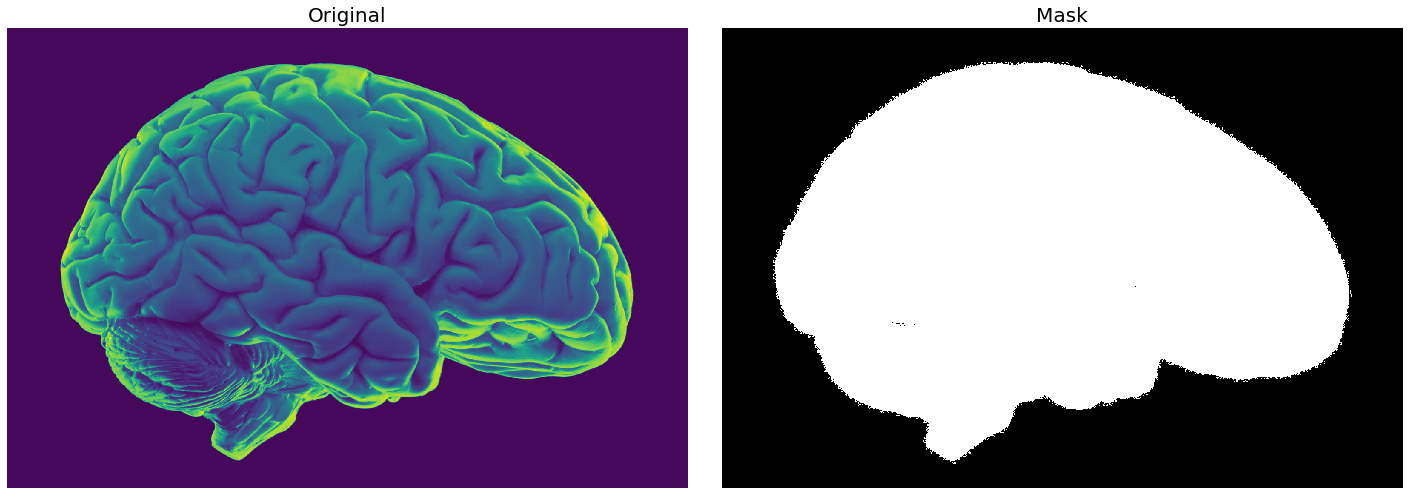

In [0]:
brain = Image.open('brain.jpg').convert("L")
brain = np.array(brain)
print("Number unique values in original image:")
print(len(np.unique(brain)), brain.shape)

mask = copy.deepcopy(brain)

print(len(np.unique(mask)))
mask[mask > 5] = 255
mask[mask == 255] = 0
mask[mask > 0] = 255
#mask[mask < 255] = 0

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25,25))
ax[0].set_title("Original", 
                fontsize=20)
ax[0].imshow(brain)
ax[0].axis("off")  

ax[1].set_title("Mask", 
                fontsize=20) 
ax[1].imshow(mask, cmap="binary");
ax[1].axis("off")   

plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [0]:
def makeWordCloud(numWords, data, img_name, mask=None, color=None):
    topic_words = [ z.lower() for y in
                        [ x[0] for x in data.values()]
                        for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          max_words=numWords,
                          width=1600, height=1080,
                          mask=mask,
                          contour_width=3, 
                          contour_color=color,
                         ).generate(word_string)

    wordcloud.to_file(f"{img_name}.png")

    return wordcloud

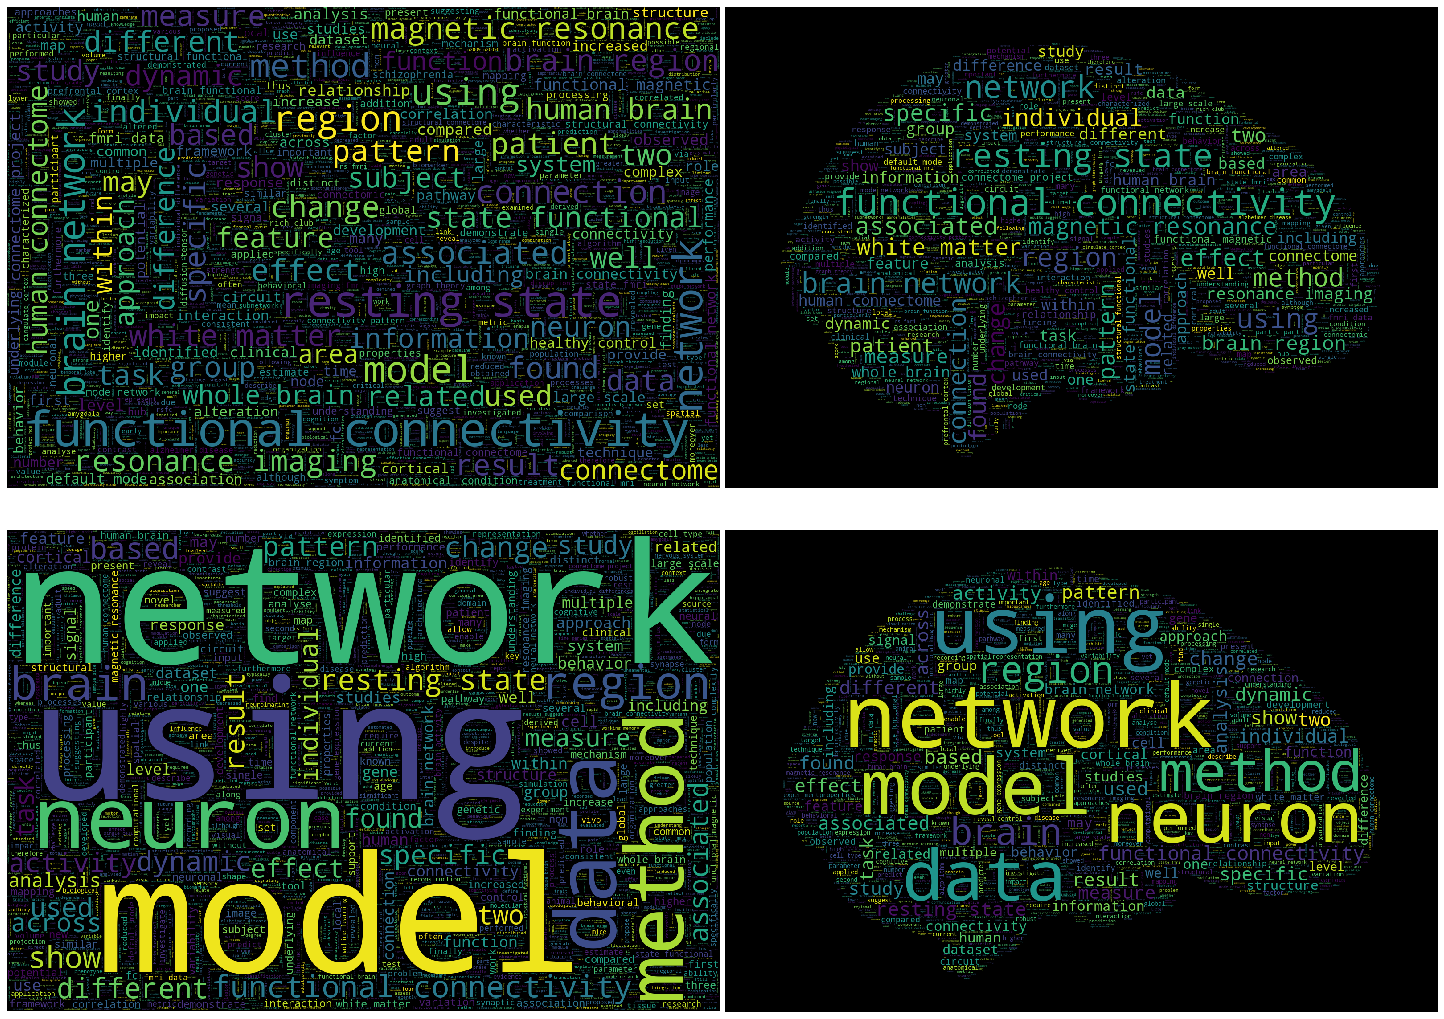

In [0]:
pubmed = makeWordCloud(10000000, 
                       pubmed_MAP,
                       "pubmed_worldcloud")

pubmed_with_mask = makeWordCloud(10000000,
                                 pubmed_MAP,
                                 "pubmed_worldcloud_with_mask",
                                 mask=mask)
biorxiv = makeWordCloud(10000000, 
                        biorxiv_MAP,
                        "biorxiv_worldcloud")

biorxiv_with_mask = makeWordCloud(10000000,
                                  biorxiv_MAP,
                                  "biorxiv_worldcloud_with_mask",
                                  mask=mask)


fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(20, 15))

ax[0, 0].imshow(pubmed);
ax[0, 0].axis("off")   
ax[0, 1].imshow(pubmed_with_mask);
ax[0, 1].axis("off")   

ax[1, 0].imshow(biorxiv);
ax[1, 0].axis("off")   
ax[1, 1].imshow(biorxiv_with_mask);
ax[1, 1].axis("off") 

plt.tight_layout(pad=.5, w_pad=.5, h_pad=.5);
plt.show()

# Word2Vec

**Now let's train word2vec on our data.**

### Data preparation.

In [0]:
#data has format:
for idx, i in enumerate([x for x in pubmed_MAP.items()]):
    print(i[0])
    print(i[1][1])
    print(i[1][0][0])
    break

https://www.ncbi.nlm.nih.gov/pubmed/31348912
Dissociating individual connectome traits using low-rank learning.
Intrinsic functional connectivity (FC) exhibits high variability across individuals, which may account for the diversity of cognitive and behavioural ability. This variability in connectivity could be attributed to individual-specific trait and inter-session state differences (intra-subject differences), as well as a small amount of noise. However, it is still a challenge to perform accurate identification of connectivity traits from FC. Here, we introduced a novel low-rank learning model to solve this problem with a new constraint item that could reduce intra-subject differences. The model could dissociate FC into a substrate (substrate) that delineates functional characteristics common across the population and connectivity traits that are expected to account for individual behavioural differences. Subsequently, we performed a sparse dictionary learning algorithm on the ext

In [0]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

import re
import codecs
import re
import codecs
import multiprocessing
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Data preparation 

def preprocess_text(text):
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

def get_sentences(data, site):
    if site == "pubmed":
        text = [i for i in [x[0] for x in data.values()]]
    else:
        try:
            text = [i for i in [x[0][0] for x in data.values()]]
        except:
            text = [i for i in [x[0] for x in data.values()]]
            
    stop_words = stopwords.words('english')
    print("Num articles:", len(text))
    text = "".join(str(text))
    sentences = []
    for sentence in nltk.sent_tokenize(text, "english"): 
        sentence = preprocess_text(sentence).lower()
        clear_text = [word for word in sentence.split() if word not in stop_words]

        clear_text = " ".join(clear_text).strip()
        sentences.append(clear_text.lower().split())

    print("Num senteces:", len(sentences))
    return sentences

pubmed_sentences = get_sentences(pubmed_MAP, "pubmed")
biorxiv_sentences = get_sentences(biorxiv_MAP, "bioarchiv")


Num articles: 4500
Num senteces: 33363
Num articles: 2368
Num senteces: 18035


In [0]:
# Train

biorxiv_model = Word2Vec(biorxiv_sentences,
                   size=200,
                   window=5,
                   min_count=3, 
                   workers=multiprocessing.cpu_count())
pubmed_model = Word2Vec(pubmed_sentences,
                   size=200,
                   window=5,
                   min_count=3, 
                   workers=multiprocessing.cpu_count())


def get_embedds_and_words(model):
    embeddings = []
    words = []

    for word in list(model.wv.vocab):
        embeddings.append(model.wv[word])
        words.append(word)
        
    return embeddings, words


pubmed_sentences = get_sentences(pubmed_MAP, "pubmed")
biorxiv_sentences = get_sentences(biorxiv_MAP, "bioarchiv")
biorxiv_model = Word2Vec(biorxiv_sentences,
                   size=200,
                   window=5,
                   min_count=3, 
                   workers=multiprocessing.cpu_count())
pubmed_model = Word2Vec(pubmed_sentences,
                   size=200,
                   window=5,
                   min_count=3, 
                   workers=multiprocessing.cpu_count())

biorxiv_embeddings, biorxiv_words = get_embedds_and_words(biorxiv_model)
pubmed_embeddings, pubmed_words = get_embedds_and_words(pubmed_model)

Num articles: 4500
Num senteces: 33363
Num articles: 2368
Num senteces: 18035


# t-SNE
### Now we visualize vector representations of words using t-SNE

In [0]:
%%time
# Train
from sklearn.manifold import TSNE
import numpy as np

def get_tsna_2d(embeddings, p=30, n_iter=3500):
    tsne = TSNE(perplexity=p,
                      n_components=2,
                      init='pca', 
                      n_iter=n_iter,
                      random_state=36)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

def get_tsna_3d(embeddings, p=30, n_iter=3500):
    tsne = TSNE(perplexity=p,
                      n_components=3,
                      init='pca', 
                      n_iter=n_iter,
                      random_state=36)
    embeddings_3d = tsne.fit_transform(embeddings)
    return embeddings_3d


biorxiv_embeddings_2d = get_tsna_2d(biorxiv_embeddings)
biorxiv_embeddings_3d = get_tsna_3d(biorxiv_embeddings)

pubmed_embeddings_2d = get_tsna_2d(pubmed_embeddings)
pubmed_embeddings_3d = get_tsna_3d(pubmed_embeddings)

**Visualizing vector representations of words in 2d and 3d**

In [0]:
from PIL import Image
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# set theme
sns.set_context("poster", font_scale=0.8, rc={"lines.markersize": 6.})

def get_color():
    color = random.choice(["mediumspringgreen",
                           "cyan",
                           "darkcyan",
                           "mediumvioletred",
                           "seagreen",
                           "purple",
                           "darkmagenta"])
    return color


def tsne_plot_2d(filename, label, embeddings, words=[], a=1, color=get_color()):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=color, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.axis("off")



**bioRxiv**

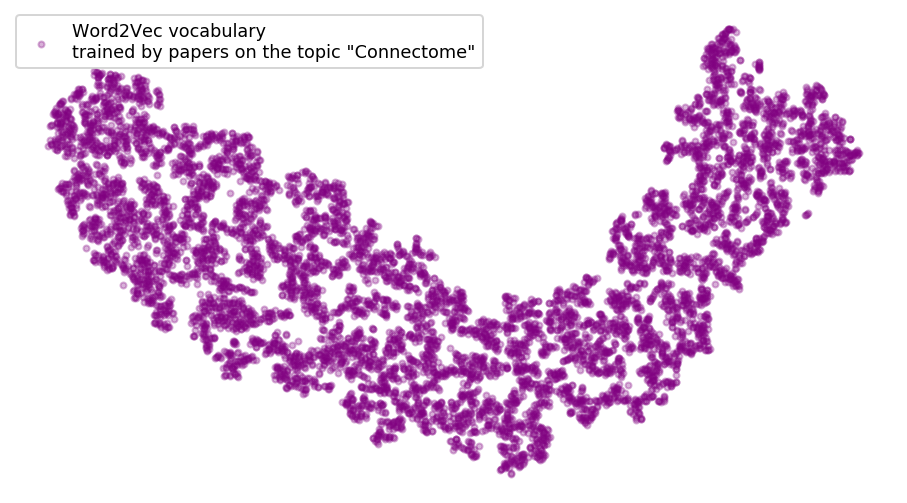

In [0]:
tsne_plot_2d(filename="biorxiv_tsne_2d_dots.png",
             label='Word2Vec vocabulary \ntrained by papers on the topic "Connectome"',
             embeddings=biorxiv_embeddings_2d,
             a=0.3)

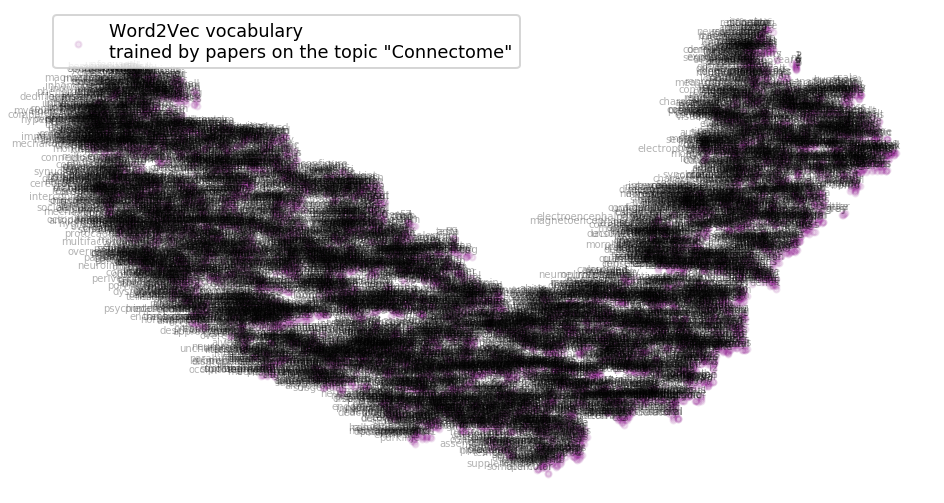

In [0]:
tsne_plot_2d(filename="biorxiv_tsne_2d_words.png",
             label='Word2Vec vocabulary \ntrained by papers on the topic "Connectome"',
             embeddings=biorxiv_embeddings_2d,
             words=biorxiv_words,
             a=0.1)

**PubMed**

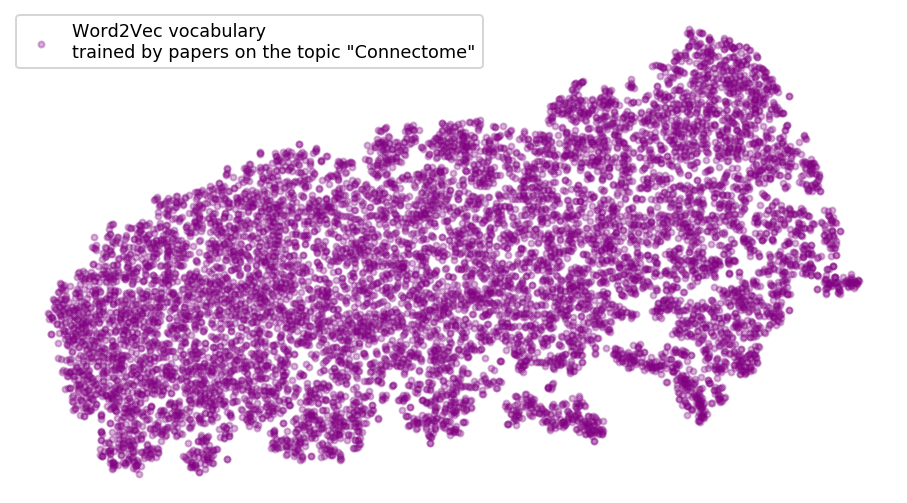

In [0]:
tsne_plot_2d(filename="pubmed_tsne_2d_dots.png",
             label='Word2Vec vocabulary \ntrained by papers on the topic "Connectome"',
             embeddings=pubmed_embeddings_2d,
             a=0.3)

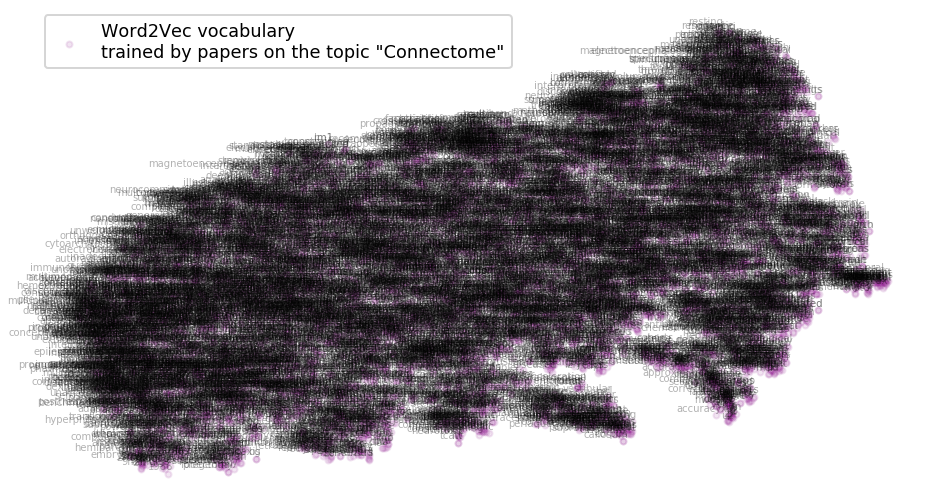

In [0]:
tsne_plot_2d(filename="pubmed_tsne_2d_words.png",
             label='Word2Vec vocabulary \ntrained by papers on the topic "Connectome"',
             embeddings=pubmed_embeddings_2d,
             words=pubmed_words,
             a=0.1)

**Let's make GIF**

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

sns.set_context("poster", font_scale=0.5, rc={"lines.markersize": 6.})

import os
import tempfile
import imageio
import shutil


def tsne_plot_3d_gif(title,
                     label,
                     embeddings,
                     c="darkslategray",
                     filename="3d.gif",
                     a=0.4):
    
    fig = plt.figure(figsize=(15,10))
    ax = Axes3D(fig)

    a = plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=c, alpha=a)

    plt.title(title, fontsize=18)

    red_patch = mpatches.Patch(color=c, label=label)
    plt.legend(handles=[red_patch], loc=3, fontsize=15)

    dirpath = tempfile.mkdtemp()
    images = []
    for angle in range(0, 360, 5):
        ax.view_init(30, angle)
        fname = os.path.join(dirpath, str(angle) + '.png')
        plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
        images.append(imageio.imread(fname))
    imageio.mimsave(filename, images)
    shutil.rmtree(dirpath)

**bioRxiv**

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


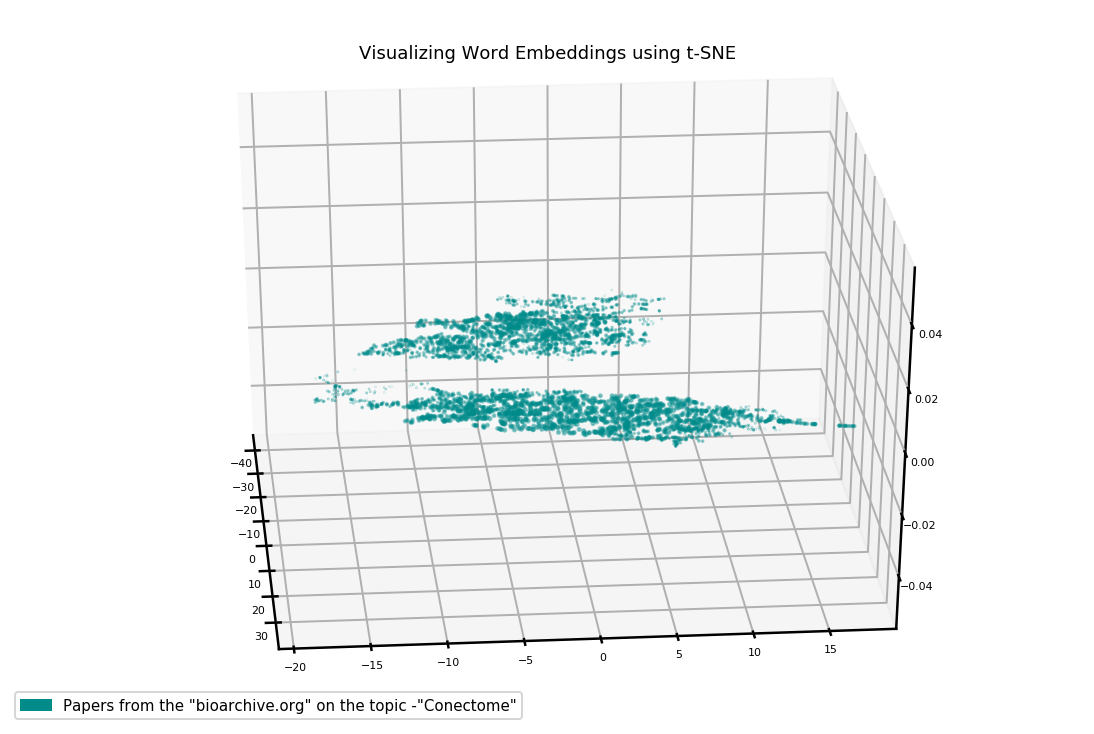

In [0]:
tsne_plot_3d_gif(title='Visualizing Word Embeddings using t-SNE',
                 label='Papers from the "bioarchive.org" on the topic -"Conectome"',
                 embeddings=biorxiv_embeddings_3d, 
                 c=get_color(),
                 filename='biorxiv_3d.gif')

**PubMed**

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


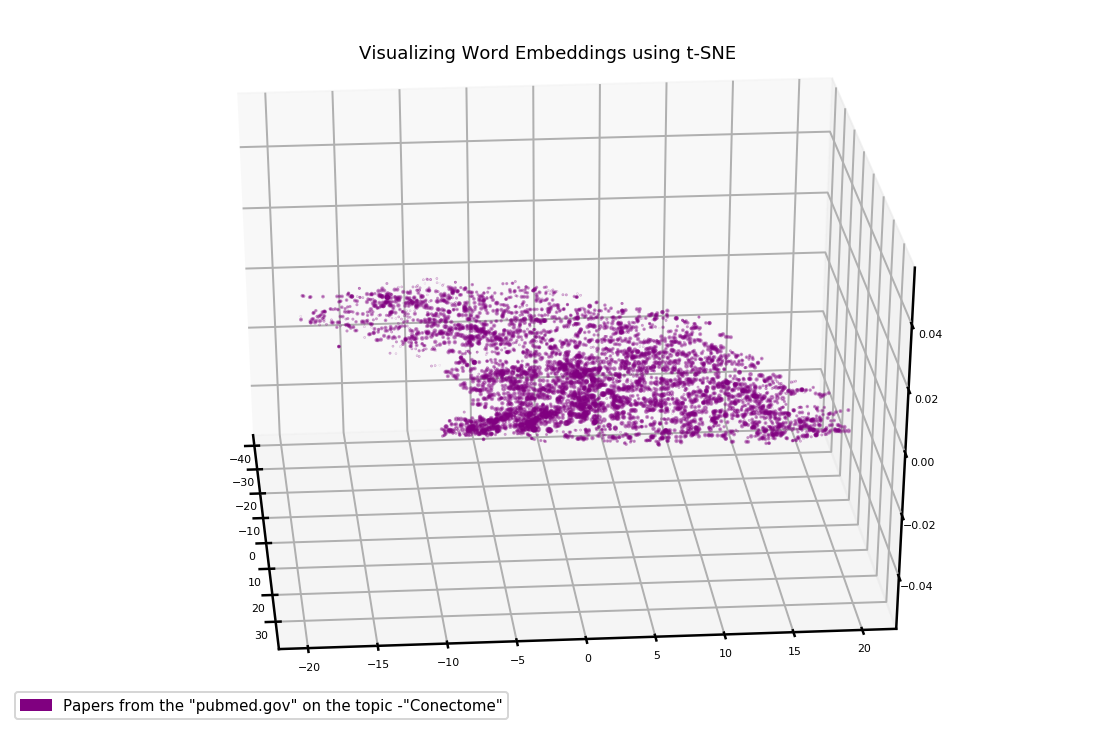

In [0]:
tsne_plot_3d_gif(title='Visualizing Word Embeddings using t-SNE',
                 label='Papers from the "pubmed.gov" on the topic -"Conectome"',
                 embeddings=pubmed_embeddings_3d, 
                 c=get_color(),
                 filename='pubmed_3d.gif')

and let's look at clusters of similar words

In [0]:
import random
import matplotlib.colors as mcolors

def get_2d_clusters(model,
                    k_words,
                    n_top_words,
                    p=15,
                    n_iter=3200):

    keys = random.choices(list(model.wv.vocab.keys()), k=k_words)

    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in model.most_similar(word, topn=n_top_words):
            words.append(similar_word)
            embeddings.append(model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    # Find tsne coordinats for 2 dimensions
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_2d = TSNE(perplexity=p,
                         n_components=2,
                         init='pca',
                         n_iter=n_iter,
                         random_state=36)
    
    embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    return keys, embeddings_2d, word_clusters

b_keys, b_embeddings_2d, b_word_clusters =  get_2d_clusters(biorxiv_model, k_words=30, n_top_words=30)
p_keys, p_embeddings_2d, p_word_clusters =  get_2d_clusters(pubmed_model, k_words=30, n_top_words=30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedin

In [0]:
import matplotlib.colors as mcolors
import random

sns.set_context("poster", font_scale=0.6, rc={"lines.linewidth": 0.7})

def tsne_plot_similar_words(title,
                            labels,
                            embedding_clusters,
                            word_clusters,
                            a,
                            filename):
    plt.figure(figsize=(20, 15))
    colors = random.choices(list(mcolors.CSS4_COLORS.keys()),k=len(labels))
    idx_color = 0
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):

        x = embeddings[:, 0]
        y = embeddings[:, 1]

        plt.scatter(x, y, c=colors[idx_color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        idx_color += 1

    plt.legend(loc=4, fontsize=12)
    plt.title(title, fontsize=15)
    plt.grid(True)
    plt.axis("off")
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
        

**bioRxiv**

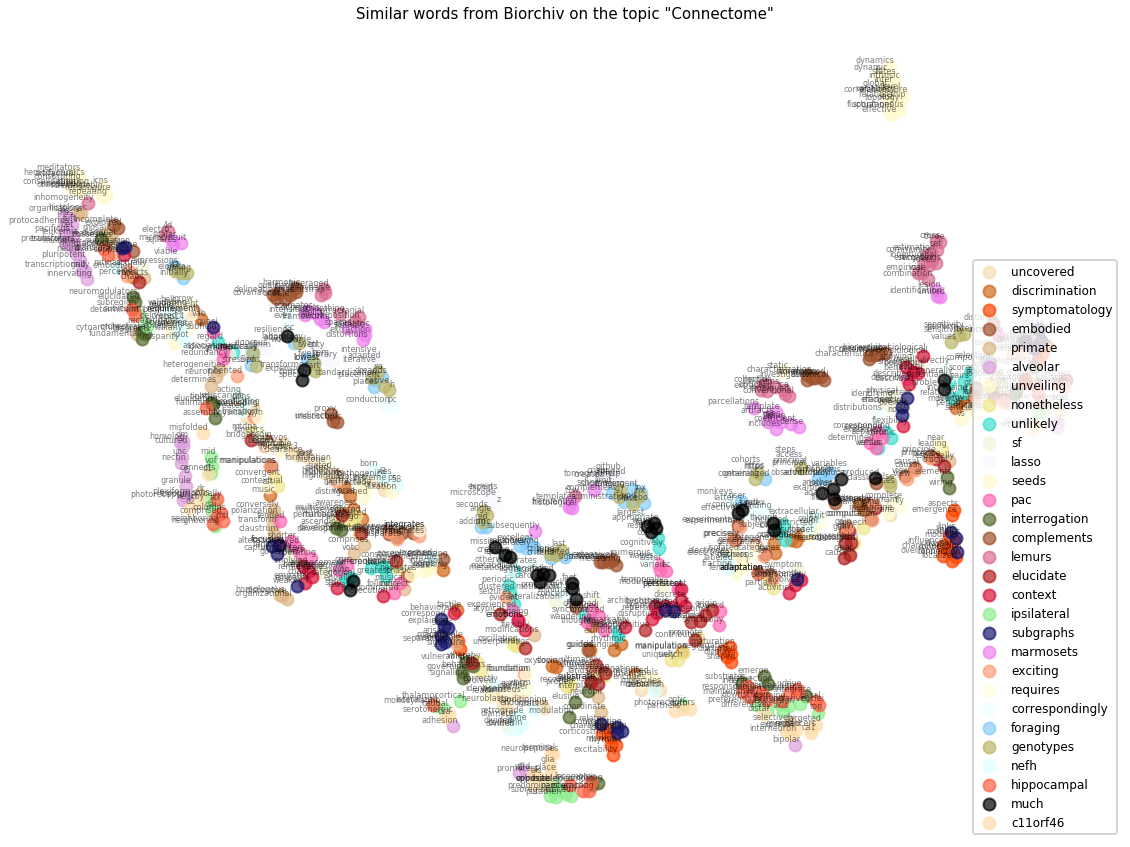

In [0]:
tsne_plot_similar_words(title='Similar words from Biorchiv on the topic "Connectome"',
                        labels=b_keys,
                        embedding_clusters=b_embeddings_2d,
                        word_clusters=b_word_clusters,
                        a=0.7,
                        filename='biorxiv_similar_words.png')

**PubMed**

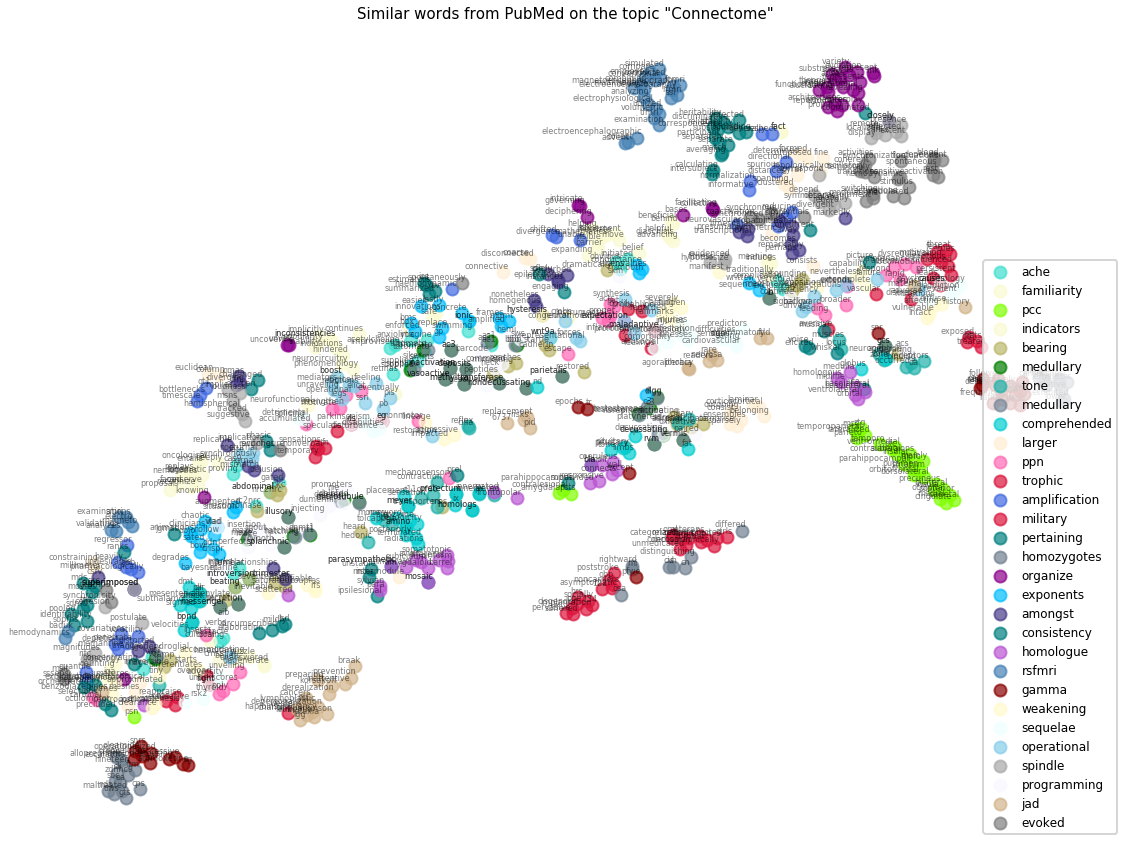

In [0]:
tsne_plot_similar_words(title='Similar words from PubMed on the topic "Connectome"',
                        labels=p_keys,
                        embedding_clusters=p_embeddings_2d,
                        word_clusters=p_word_clusters,
                        a=0.7,
                        filename='pubmed_similar_words.png')

# Create pdf

**Finally, let's combine everything into one file**

**Download representative image connectome brain from wiki**

In [0]:
! wget -O promo.jpg https://i.pinimg.com/originals/34/1a/4e/341a4edbf5ff6997b455e5bf1d524358.jpg

--2020-02-08 10:31:35--  https://i.pinimg.com/originals/34/1a/4e/341a4edbf5ff6997b455e5bf1d524358.jpg
Resolving i.pinimg.com (i.pinimg.com)... 2.20.34.192, 2a04:4e42:d::84
Connecting to i.pinimg.com (i.pinimg.com)|2.20.34.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94010 (92K) [image/jpeg]
Saving to: ‘promo.jpg’

promo.jpg           100%[===================>]  91.81K  --.-KB/s    in 0.06s   

2020-02-08 10:31:35 (1.46 MB/s) - ‘promo.jpg’ saved [94010/94010]



In [0]:
!pip install fpdf -qq

In [0]:
from fpdf import FPDF

def encode_decode(data):
    udata = data.encode()
    return udata.decode('latin-1')

def make_pdf(site,
             MAP,
             pdf_name,
             wc_name,
             wc_name_mask,
             name1_2d,
             name2_2d,
             sim_name,
             gif_name,
             theme,
             img_promo="promo.jpg"):
    
    PROLOG = f'''Web Scraping science papers from site:
    {site} on the topic - "{theme}".'''
    EPILOG = "Top Words Cloud"
    EPILOG2 = "t-SNE"
    empty = []

    # Description
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=15, style="B")

    #pdf.set_creator("Bonart")
    pdf.multi_cell(0, 8, txt=PROLOG, align="C")
    pdf.image(img_promo, x=15, y=50, w=180, link="8.8.8.8",)#
    pdf.add_page()

    # Create pdf-pages with data from dictionary
    for idx, i in enumerate([x for x in MAP.items()]):
        try:
            url = i[0]
            title = encode_decode(i[1][1])
            data = encode_decode(i[1][0][0])
            pdf.ln(10)
            pdf.set_font("Arial", size=12, style="B")
            pdf.multi_cell(0, 8, txt=title, align="L")
            pdf.set_text_color(180, 5, 100)
            pdf.cell(0, 10, txt=url, ln=1, align="L")
            pdf.set_text_color(0, 0, 0)
            pdf.set_font("Arial", size=12)
            pdf.multi_cell(0, 8, txt=data)
        except: 
            empty.append(idx)
            continue
    print("Amount of empty data:", len(empty))

    # Epilog
    pdf.add_page()
    pdf.set_font("Arial", size=15, style="B")
    pdf.multi_cell(0, 8, txt=EPILOG, align="C")
    pdf.image(f'{wc_name}.png', x=15, y=30, w=180, link="8.8.8.8")
    pdf.add_page()
    pdf.image(f'{wc_name_mask}.png', x=15, y=10, w=180, link="8.8.8.8")
    pdf.add_page()
    pdf.image(f'{name1_2d}.png', x=15, y=10, w=180, link="8.8.8.8")
    pdf.add_page()
    pdf.image(f'{name2_2d}.png', x=15, y=10, w=180, link="8.8.8.8")
    pdf.add_page()
    pdf.image(f'{sim_name}.png', x=15, y=10, w=180, link="8.8.8.8")
    pdf.add_page()
    pdf.image(gif_name, x=15, y=10, w=180, link="8.8.8.8")
    pdf.output(f"{pdf_name}.pdf")

In [0]:
!ls -l

total 82552
-rw-r--r-- 1 root root 32857538 Feb  8 10:16 biorxiv_3d.gif
-rw-r--r-- 1 root root  1514547 Feb  8 10:23 biorxiv_similar_words.png
-rw-r--r-- 1 root root  1009868 Feb  8 10:10 biorxiv_tsne_2d_dots.png
-rw-r--r-- 1 root root  2074686 Feb  8 10:11 biorxiv_tsne_2d_words.png
-rw-r--r-- 1 root root  1357077 Feb  8 08:06 biorxiv_worldcloud.png
-rw-r--r-- 1 root root   739848 Feb  8 08:06 biorxiv_worldcloud_with_mask.png
-rw-r--r-- 1 root root   432615 Feb  2  2017 brain.jpg
-rw-r--r-- 1 root root    94010 Feb  8 10:31 promo.jpg
-rw-r--r-- 1 root root 36370688 Feb  8 10:18 pubmed_3d.gif
-rw-r--r-- 1 root root  1642767 Feb  8 10:23 pubmed_similar_words.png
-rw-r--r-- 1 root root  1508869 Feb  8 10:12 pubmed_tsne_2d_dots.png
-rw-r--r-- 1 root root  2781194 Feb  8 10:13 pubmed_tsne_2d_words.png
-rw-r--r-- 1 root root  1420970 Feb  8 08:04 pubmed_worldcloud.png
-rw-r--r-- 1 root root   697730 Feb  8 08:05 pubmed_worldcloud_with_mask.png
drwxr-xr-x 1 root root     4096 Feb  5 18:37 sam

In [0]:
 make_pdf(site="bioRxiv",
          MAP=biorxiv_MAP,
          pdf_name="bioRxiv",
          wc_name="biorxiv_worldcloud",
          wc_name_mask="biorxiv_worldcloud_with_mask",
          name1_2d="biorxiv_tsne_2d_dots",
          name2_2d="biorxiv_tsne_2d_words",
          sim_name="biorxiv_similar_words",
          gif_name="biorxiv_3d.gif",
          theme="Connectome")

    
make_pdf(site="PubMed",
         MAP=pubmed_MAP,
         pdf_name="PubMed",
         wc_name="pubmed_worldcloud",
         wc_name_mask="pubmed_worldcloud_with_mask",
         name1_2d="pubmed_tsne_2d_dots",
         name2_2d="pubmed_tsne_2d_words",
         sim_name="pubmed_similar_words",
         gif_name="pubmed_3d.gif",
         theme="Connectome")

Amount of empty data: 0
Amount of empty data: 138


In [0]:
from IPython.display import FileLink, FileLinks
FileLinks('.')

./
  pubmed_3d.gif
  biorxiv_worldcloud.png
  biorxiv_similar_words.png
  bioRxiv.pdf
  pubmed_tsne_2d_words.png
  biorxiv_3d.gif
  biorxiv_tsne_2d_words.png
  PubMed.pdf
  pubmed_similar_words.png
  brain.jpg
  pubmed_worldcloud.png
  promo.jpg
  biorxiv_tsne_2d_dots.png
  pubmed_worldcloud_with_mask.png
  pubmed_tsne_2d_dots.png
  biorxiv_worldcloud_with_mask.png
./.config/
  .last_survey_prompt.yaml
  active_config
  gce
  config_sentinel
  .last_update_check.json
  .metricsUUID
./.config/configurations/
  config_default
./.config/logs/2020.02.05/
  18.37.01.637056.log
  18.36.15.774867.log
  18.36.48.819796.log
  18.36.32.968039.log
  18.37.02.083241.log
  18.36.45.012839.log
./sample_data/
  anscombe.json
  README.md
  california_housing_train.csv
  mnist_train_small.csv
  california_housing_test.csv
  mnist_test.csv